In [18]:
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch

In [19]:
# Load Dataset
df = pd.read_csv('../data/clean_data.csv')

In [20]:
# Classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

Device set to use mps:0


In [21]:
# as identified prior to domain specific stop word 
KMeans_labels = [
    "credit reporting issues",
    "identity theft",
    "legal or regulatory issues",
    "credit report fraud/inquiries",
    "payment issues"
]
refined_KMeans_labels = [
    "debt collection",
    "identity theft",
    "payment and loan issues",
    "account reporting",
    "legal or regulatory"
]
human_labels = [
    "billing issues",
    "fraud", 
    "customer service",
    "student loans",
    "job loss"
]

In [26]:
def classify_narrative(text, labels):
    result = classifier(str(text), labels)
    return result['labels'][0]

tqdm.pandas()
df['predicted_category'] = df['consumer_complaint_narrative'].progress_apply(
    lambda x: classify_narrative(x, refined_KMeans_labels))

100%|██████████| 1000/1000 [06:54<00:00,  2.41it/s]


                        consumer_complaint_narrative       predicted_category
0  this is my multiple endeavor to tell you that ...           identity theft
1  on approximately xxxx19 i took advantage of an...           payment issues
2  the money transfer got cancelled last minute f...           payment issues
3  on xxxx xxxx xxxx i contacted monterey collect...           payment issues
4  the credit bureau stated my account was proper...  credit reporting issues


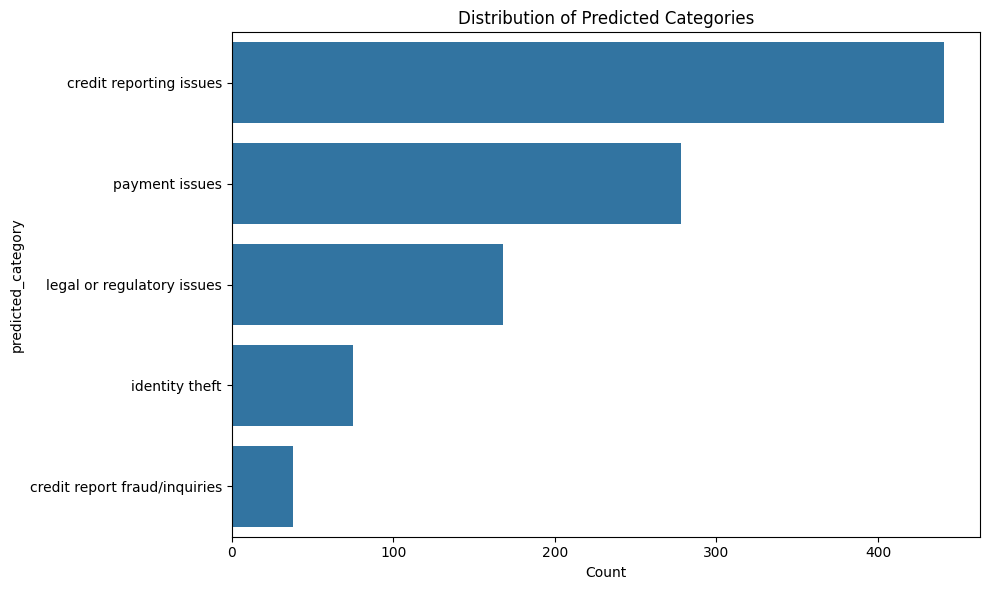

In [27]:
print(df[['consumer_complaint_narrative', 'predicted_category']].head())
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='predicted_category', order=df['predicted_category'].value_counts().index)
plt.title('Distribution of Predicted Categories')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

In [22]:
# Extract confidence scores from results
def get_confidence(text, labels):
    result = classifier(str(text), labels)
    return result['scores'][0]

tqdm.pandas()
confidence_scores = df['consumer_complaint_narrative'].progress_apply(lambda x: get_confidence(x, refined_KMeans_labels))

print(f"Average confidence score: {confidence_scores.mean():.3f}")
print(f"Confidence score distribution:")
print(confidence_scores.describe())

# Update df with separated category and confidence columns for visualization
#df['category'] = categories
#df['confidence'] = confidence_scores

  0%|          | 34/1407942 [00:16<184:13:34,  2.12it/s]


KeyboardInterrupt: 

In [16]:
# Export model processed dataset
df['confidence_score'] = confidence_scores
df.to_csv('../data/data_predictiions.csv', index=True)